# Implimentation of a small "Wide ResNet"
Based on a lecture by [Fawaz Sammani](https://github.com/fawazsammani)

In [16]:
import pickle
import os
import numpy as np
import pandas as pd
import torch
from trainers import ClassifierTrainer
from wide_resnet import make_resnet_architecture, BasicBlock, WideResnet
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as Tr
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import random

In [17]:
class CIFARDataset(Dataset):

    def __init__(self,path,filenames,transform=None):
        self.data_dict = self.load_data(path,filenames)
        self.class_names = self.unpickle(os.path.join(path,'batches.meta'))[b'label_names']
        self.class_names = list(map(lambda x: x.decode('UTF-8'), self.class_names))
        self.images = self.data_dict[b'data'].reshape(-1,3,32,32)
        self.labels = self.data_dict[b'labels']
        self.transform = transform
        
    def __getitem__(self,index):
        # Get one item from the dataset
        sample = self.images[index]
        if self.transform:
            img = Image.fromarray(sample.T)
            sample = np.asanyarray(self.transform(img))
            sample = sample.T
        sample = sample/255
        label = self.labels[index]
        sample = torch.tensor(sample).float()
        label = torch.tensor(label)
        return sample, label
    
    def __len__(self):
        return len(self.images)
    
    def load_data(self,path,filenames):
        data_dict = {}
        for filename in filenames:
            batch_dict = self.unpickle(os.path.join(path_data,filename))
            if len(data_dict)==0:
                data_dict = batch_dict
            else:
                data_dict[b'labels'] += batch_dict[b'labels']  
                data_dict[b'data'] = np.vstack((data_dict[b'data'],batch_dict[b'data']))
        return data_dict
    
    def unpickle(self,file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

In [18]:
def show_sample_image(dataset, idx=0, add_title=True, ax=None):
    image, label = dataset[idx]
    label = int(label.item())
    image = image.numpy().T
    flipped_image = np.zeros(image.shape)
    flipped_image[:,:, 0] = image[:,:, 0].T
    flipped_image[:,:, 1] = image[:,:, 1].T
    flipped_image[:,:, 2] = image[:,:, 2].T
    label_name = dataset.class_names[label]
    if ax is None:
        _, ax = plt.subplots(figsize=(1,1))
    ax.imshow(flipped_image, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    if add_title:
        ax.set_title(label_name)
    return flipped_image, label, label_name, ax

# Setup the datasets

In [19]:
path_data = './data/cifar-10-batches-py/'
batchfiles = os.listdir(path_data)
train_batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
test_batches = ['test_batch']

batch_size = 100

### Data Augmentation

In [20]:
#transforms = Tr.AutoAugment(Tr.AutoAugmentPolicy.CIFAR10)
transforms = Tr.Compose([Tr.Pad(4),
                         Tr.RandomHorizontalFlip(),
                         Tr.RandomCrop(32)])


In [21]:
train_dataset = CIFARDataset(path_data, train_batches, transform=transforms)
test_dataset = CIFARDataset(path_data, test_batches)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

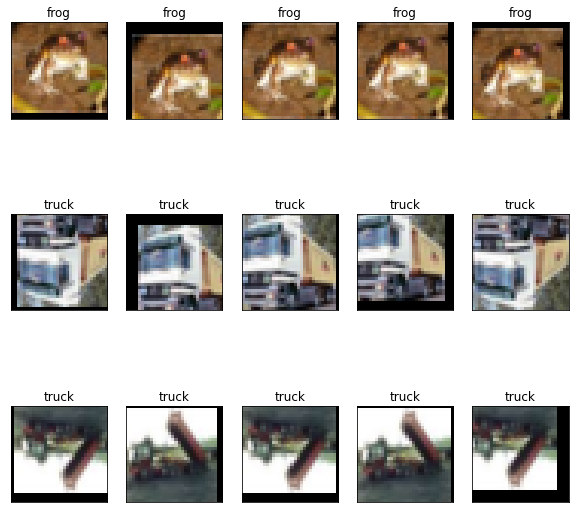

In [22]:
dataset = train_dataset

nrows = 3
ncols = 5
fig, axs = plt.subplots(nrows, ncols, squeeze=False, figsize=(10,10))


for i in range(nrows):
    for j in range(ncols):
        image, _, _, ax = show_sample_image(dataset, i,ax=axs[i,j], add_title=True)
    

# Train the mdel

**ResNet architecture with k=1**

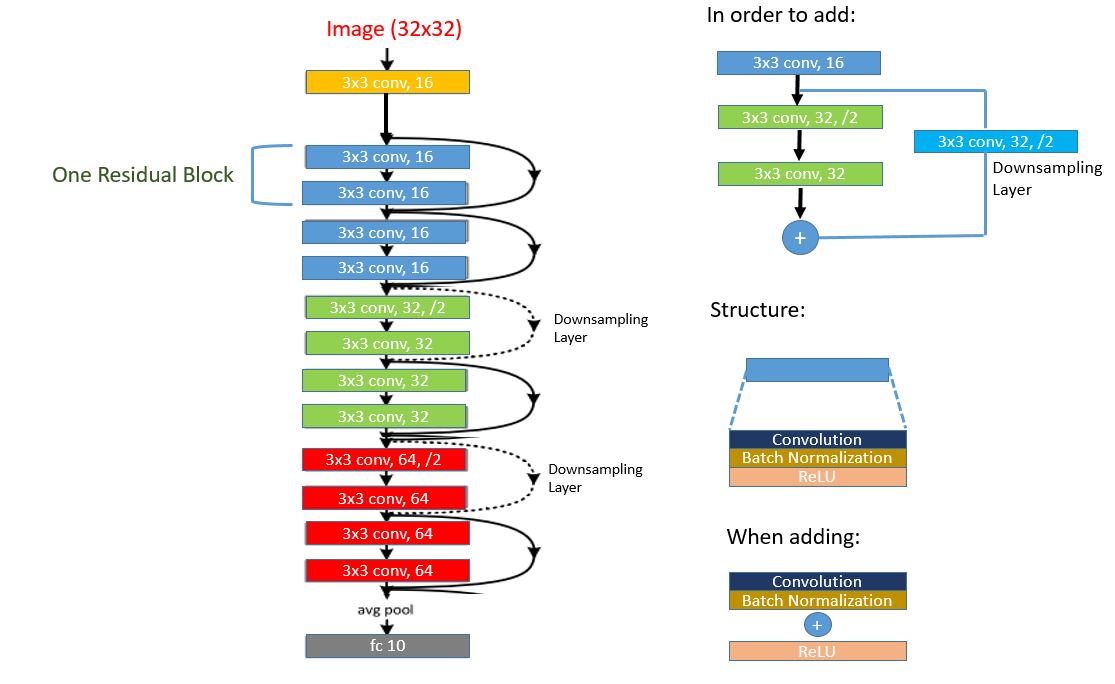

In [23]:
# Make model architecture
architecture = make_resnet_architecture(k=5)

In [24]:
#Learning rate
learning_rate = learning_rate = 0.001
#Number of pochs
num_epochs = 130
#Initialize the model
model = WideResnet(architecture, BasicBlock)
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Create a learning rate scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
#scheduler = None

In [25]:
trainer = ClassifierTrainer(model, optimizer,
                            train_loader, test_loader, scheduler)

In [26]:
%%time
trainer.fit(num_epochs)

Epoch 1/130, Training Loss: 1.499, Training Accuracy: 0.446, Testing Loss: 1.261, Testing Acc: 0.540
Epoch 2/130, Training Loss: 1.124, Training Accuracy: 0.594, Testing Loss: 1.217, Testing Acc: 0.571
Epoch 3/130, Training Loss: 0.961, Training Accuracy: 0.660, Testing Loss: 0.944, Testing Acc: 0.669
Epoch 4/130, Training Loss: 0.846, Training Accuracy: 0.700, Testing Loss: 1.341, Testing Acc: 0.563
Epoch 5/130, Training Loss: 0.756, Training Accuracy: 0.731, Testing Loss: 0.825, Testing Acc: 0.705
Epoch 6/130, Training Loss: 0.685, Training Accuracy: 0.758, Testing Loss: 0.855, Testing Acc: 0.714
Epoch 7/130, Training Loss: 0.633, Training Accuracy: 0.775, Testing Loss: 0.958, Testing Acc: 0.685
Epoch 8/130, Training Loss: 0.587, Training Accuracy: 0.794, Testing Loss: 0.662, Testing Acc: 0.767
Epoch 9/130, Training Loss: 0.546, Training Accuracy: 0.808, Testing Loss: 0.641, Testing Acc: 0.785
Epoch 10/130, Training Loss: 0.510, Training Accuracy: 0.820, Testing Loss: 0.593, Testing 

Epoch 82/130, Training Loss: 0.045, Training Accuracy: 0.984, Testing Loss: 0.666, Testing Acc: 0.871
Epoch 83/130, Training Loss: 0.045, Training Accuracy: 0.985, Testing Loss: 0.705, Testing Acc: 0.868
Epoch 84/130, Training Loss: 0.044, Training Accuracy: 0.985, Testing Loss: 0.650, Testing Acc: 0.872
Epoch 85/130, Training Loss: 0.043, Training Accuracy: 0.985, Testing Loss: 0.719, Testing Acc: 0.865
Epoch 86/130, Training Loss: 0.046, Training Accuracy: 0.984, Testing Loss: 0.691, Testing Acc: 0.868
Epoch 87/130, Training Loss: 0.046, Training Accuracy: 0.984, Testing Loss: 0.670, Testing Acc: 0.873
Epoch 88/130, Training Loss: 0.040, Training Accuracy: 0.986, Testing Loss: 0.678, Testing Acc: 0.874
Epoch 89/130, Training Loss: 0.042, Training Accuracy: 0.985, Testing Loss: 0.676, Testing Acc: 0.871
Epoch 90/130, Training Loss: 0.041, Training Accuracy: 0.986, Testing Loss: 0.678, Testing Acc: 0.872
Epoch 91/130, Training Loss: 0.045, Training Accuracy: 0.985, Testing Loss: 0.654,

In [27]:
model_file = './models/cifar10_miniwrn_v3_140922'
trainer.save_model(model_file)

# Model Evaluation

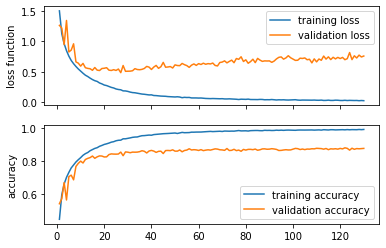

In [28]:
epochs = list(range(1,num_epochs+1))

fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(epochs, trainer.train_losses)
axs[0].plot(epochs, trainer.test_losses)
axs[0].set_ylabel('loss function')
axs[0].legend(['training loss', 'validation loss'])
axs[1].plot(epochs, trainer.train_accuracies)
axs[1].plot(epochs, trainer.test_accuracies)
axs[1].set_ylabel('accuracy')
axs[1].legend(['training accuracy', 'validation accuracy'])

In [29]:
trainer.test_accuracies[-1]

0.8761999011039734

# Visualize predictions

accuracy for the presented 25 images: 0.84


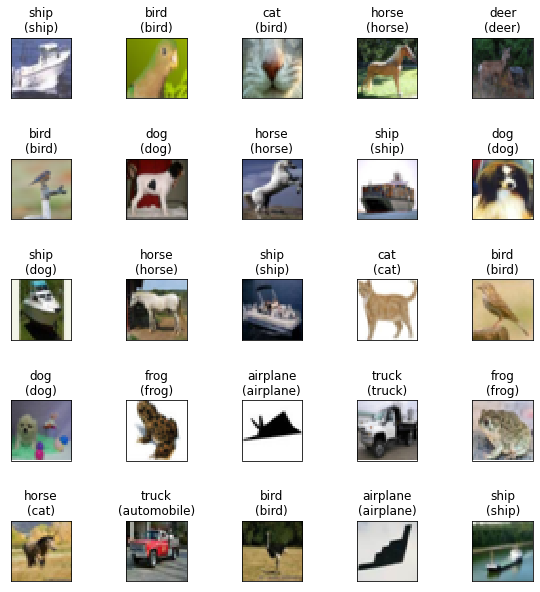

In [36]:
dataset = test_dataset

nrows = 5
ncols = 5
fig, axs = plt.subplots(nrows, ncols, squeeze=False, figsize=(10,10))

accuracy = 0

for i in range(nrows):
    for j in range(ncols):
        idx = random.randint(0,len(dataset)-1)
        prediction = trainer.predict(dataset, idx)
        prediction_name = dataset.class_names[prediction]
        _, label, label_name, ax = show_sample_image(dataset, idx,ax=axs[i,j], add_title=False)
        ax.set_title(label_name + '\n(' + prediction_name +')')
        plt.subplots_adjust(hspace=1)
        accuracy +=1/(nrows*ncols)*float(prediction==label)
        
print('accuracy for the presented '+str(nrows*ncols)+' images: '+str(round(accuracy,2)))